In [31]:
#############################################
# SECTION 1: IMPORT PACKAGES & DATASET CONFIGURATION
#############################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fredapi import Fred
from statsmodels.tsa.statespace.mlemodel import MLEModel
from sklearn.decomposition import PCA

# Initialize FRED API (replace with your API key)
api_key = "ada1a8ba0569ed784226f2c26db44ab1"
fred = Fred(api_key=api_key)

# Define factor blocks (using only valid FRED IDs)
factor_blocks = {
    'Global': [
        'GDPC1',     # Real Gross Domestic Product (quarterly)
        'INDPRO',    # Industrial Production Index (monthly)
        'DSPIC96',   # Real Disposable Personal Income (monthly)
        'WEI',       # Weekly Economic Index (weekly)
        'DGS10',     # 10-Year Treasury Yield (daily)
        'DGS2',      # 2-Year Treasury Yield (daily)
        'DCOILWTICO',# Crude Oil Price: WTI (daily)
        'SP500',     # S&P 500 (daily)
        'PCEC',      # Real Personal Consumption Expenditures (monthly)
        'GPDI',      # Gross Private Domestic Investment (quarterly)
        'GDPDEF'     # GDP Price Deflator (quarterly)
    ],
    'Labor': [
        'PAYEMS',    # Total Nonfarm Payroll Employment (monthly)
        'JTSJOL',    # Job Openings (monthly)
        'UNRATE',    # Unemployment Rate (monthly)
        'ICSA',      # Initial Claims (weekly)
        'CCSA',      # Continuing Claims (weekly)
        'AHETPI',    # Avg Hourly Earnings, Production Workers (monthly)
        'AWHNONAG',  # Avg Weekly Hours, Total Nonfarm (monthly)
        'CE16OV'     # Civilian Labor Force: Employed, Total (monthly)
    ],
    'Inflation': [
        'CPIAUCSL',  # CPI for All Urban Consumers (monthly)
        'CPILFESL',  # CPI Less Food and Energy (monthly)
        'PCEPI',     # Personal Consumption Expenditures Price Index (monthly)
        'WM2NS'      # M2 Money Stock (weekly)
    ],
    'Housing': [
        'HOUST',     # Housing Starts (monthly)
        'PERMIT',    # Building Permits (monthly)
        'HSN1F',     # New Single-Family Houses Sold (monthly)
        'HPIPONM226S'# Alternative Housing Starts series
    ],
    'Surveys': [
        'GACDISA066MSFRBNY',  # Empire State Manufacturing Survey (monthly)
        'GACDFSA066MSFRBPHI',  # Philadelphia Fed Manufacturing Survey (monthly)
        'UMCSENT'             # University of Michigan Consumer Sentiment (monthly)
    ],
    'Financial': [
        'FEDFUNDS',  # Federal Funds Rate (daily)
        'TB3MS',     # 3-Month Treasury Bill Rate (daily)
        'TB6MS',     # 6-Month Treasury Bill Rate (daily)
        'GS1',       # 1-Year Treasury Constant Maturity Rate (daily)
        'GS5',       # 5-Year Treasury Constant Maturity Rate (daily)
        'AAA',       # Moody's Aaa Corporate Bond Yield (daily)
        'BAA',       # Moody's Baa Corporate Bond Yield (daily)
        'M1SL',      # M1 Money Stock (weekly)
        'M2SL',      # M2 Money Stock (weekly)
        'M3SL'       # M3 Money Stock (weekly)
    ]
}

def fetch_series(series_id, start_date):
    """Fetch a single FRED series as a DataFrame."""
    s = fred.get_series(series_id, start_date)
    s = s.to_frame(name=series_id)
    s.index = pd.to_datetime(s.index)
    return s

In [32]:
#############################################
# SECTION 2: MERGE DATA INTO WEEKLY INDEX & STANDARDIZE
#############################################
# Determine most recent date over all series
max_date = max(s.index.max() for s in raw_series_data.values()) if 'raw_series_data' in globals() \
            else None
# Instead, build raw_series_data on the fly:
raw_series_data = {}
for cat, serlist in factor_blocks.items():
    for sid in serlist:
        try:
            raw_series_data[sid] = fetch_series(sid, start_date)
        except Exception as e:
            print(f"Series {sid} not found: {e}")

max_date = max(df.index.max() for df in raw_series_data.values())

# Create a weekly index from the start date to max_date
weekly_index = pd.date_range(start=start_date, end=max_date, freq="W-FRI")

# Build raw merged dataset: for low-frequency series (e.g., GDP, GPDI, GDPDEF), do not fill missing values.
block_data = {}
for block, serlist in factor_blocks.items():
    df_block = pd.DataFrame(index=weekly_index)
    for sid in serlist:
        if sid in raw_series_data:
            if sid in ['GDPC1', 'GPDI', 'GDPDEF']:
                # Leave as-is (NaNs for weeks when not reported)
                df_block[sid] = raw_series_data[sid].reindex(weekly_index)
            else:
                df_block[sid] = raw_series_data[sid].reindex(weekly_index, method='nearest')
    block_data[block] = df_block

raw_merged_data = pd.concat(list(block_data.values()), axis=1)

# Standardize each block WITHOUT filling NaNs (to let Kalman filter treat them as missing)
std_blocks = {}
for block, df in block_data.items():
    df_std = df.copy()
    for col in df.columns:
        col_mean = df[col].mean(skipna=True)
        col_std = df[col].std(skipna=True)
        if col_std in [0, None] or np.isnan(col_std):
            print(f"Skipping standardization for {col} (std zero or NaN).")
            df_std[col] = 0.0
        else:
            df_std[col] = (df[col] - col_mean) / col_std
    std_blocks[block] = df_std
data_std = pd.concat(list(std_blocks.values()), axis=1)

In [33]:
#############################################
# SECTION 3: IDENTIFICATION
#############################################
N_total = data_std.shape[1]
idx_gdp = list(data_std.columns).index("GDPC1") if "GDPC1" in data_std.columns else None
iota = np.zeros(N_total)
if idx_gdp is not None:
    iota[idx_gdp] = 1

In [34]:
#############################################
# SECTION 4: PCA INITIALIZATION
#############################################
q = 6
# For PCA, fill missing with zeros temporarily
X_pca = data_std.fillna(0).values
from numpy.linalg import eigh, inv
cov_mat = np.cov(X_pca, rowvar=False)
eigs, vecs = eigh(cov_mat)
order = np.argsort(eigs)[::-1]
vecs = vecs[:, order]
Lambda_init = vecs[:, :q]
# Initial factors from PCA:
F0 = X_pca @ Lambda_init @ inv(Lambda_init.T @ Lambda_init)
F0 = F0.T  # shape (q, T)

In [35]:
#############################################
# SECTION 5: STATE-SPACE MODEL DEFINITION & ITERATIVE ESTIMATION WITH TREND AND DRIFT
#############################################
class DFMStateSpaceWithTrend(MLEModel):
    def __init__(self, endog, Lambda_init, iota, F_dim, mu_g_init=0.005, **kwargs):
        self.F_dim = F_dim
        self.iota = iota
        self.current_Lambda = Lambda_init.copy()
        self.mu_g_init = mu_g_init
        k_states = 1 + 2 * F_dim  # 1 (trend) + 2*q (current and lagged factors)
        super().__init__(endog, k_states=k_states, k_posdef=k_states,
                         initialization="approximate_diffuse", **kwargs)
        N = self.ssm.k_endog
        q = F_dim
        self.ssm['design'] = np.column_stack([
            iota.reshape(-1, 1),
            Lambda_init,
            np.zeros((N, q))
        ])
        self.ssm['obs_cov'] = np.eye(N)
        # State transition: g_t = g_{t-1} + μ_g + noise; factors follow a VAR(2)
        transition = np.eye(k_states)
        transition[0, 0] = 1.0  # Trend
        A1 = np.full((q,), 0.5)
        A2 = np.full((q,), 0.2)
        for i in range(q):
            transition[1 + i, 1 + i] = A1[i]
            if i + q < k_states:
                transition[1 + i, 1 + q + i] = A2[i]
        self.ssm['transition'] = np.real(transition)
        self.ssm['selection'] = np.eye(k_states)
        self.ssm['state_cov'] = np.diag(np.concatenate(([1.0], [0.1] * (2 * q))))
        state_intercept = np.zeros(k_states)
        state_intercept[0] = self.mu_g_init  # Drift term for trend
        self.ssm['state_intercept'] = state_intercept
        self.mu = np.zeros(N)
    
    def update(self, params, **kwargs):
        N = self.ssm.k_endog
        q = self.F_dim
        Lambda = params[:N*q].reshape(N, q)
        self.current_Lambda = Lambda.copy()
        design = np.column_stack([
            self.iota.reshape(-1, 1),
            Lambda,
            np.zeros((N, q))
        ])
        self.ssm['design'] = design
    
    @property
    def start_params(self):
        N = self.ssm.k_endog
        q = self.F_dim
        return self.current_Lambda.ravel()

# Build the model using standardized data:
X_model = data_std.values
model = DFMStateSpaceWithTrend(X_model, Lambda_init, iota, F_dim=q, mu_g_init=0.005)

# Iterative refinement of loadings using Kalman smoothing:
max_iter = 5
tol = 1e-3
Lambda_old = model.current_Lambda.copy()

for iteration in range(max_iter):
    res = model.smooth(model.start_params)
    sm_states = res.smoothed_state   # shape: (1 + 2*q, T)
    # Extract latent factors f_t (rows 1 to 1+q)
    F_est = sm_states[1:1+q, :].T  # shape: (T, q)
    Lambda_new = np.zeros_like(model.current_Lambda)
    for i in range(X_model.shape[1]):
        mask = ~np.isnan(X_model[:, i])
        if mask.sum() > q:
            X_i = X_model[mask, i]
            F_i = F_est[mask]
            try:
                beta = np.linalg.lstsq(F_i, X_i, rcond=None)[0]
            except np.linalg.LinAlgError:
                beta = np.linalg.pinv(F_i) @ X_i
            Lambda_new[i, :] = beta
        else:
            Lambda_new[i, :] = Lambda_old[i, :]
    diff = np.linalg.norm(Lambda_new - Lambda_old, ord='fro')
    print(f"Iteration {iteration}, Lambda update diff = {diff}")
    if np.isnan(diff) or diff < tol:
        break
    Lambda_old = Lambda_new.copy()
    model.update(Lambda_new.ravel())

final_res = model.smooth(model.start_params)
sm_states = final_res.smoothed_state
final_Lambda = model.current_Lambda  # Final estimated loading matrix
trend_est = sm_states[0, :]           # Trend component (g_t), shape (T,)
F_final = sm_states[1:1+q, :]           # Latent factors (f_t), shape (q, T)

Iteration 0, Lambda update diff = 0.5557697227008119
Iteration 1, Lambda update diff = 0.2005084602965952
Iteration 2, Lambda update diff = 0.19005296903397692
Iteration 3, Lambda update diff = 0.18574240772738923
Iteration 4, Lambda update diff = 0.18251560302931946


Most recent observation in dataset: 2025-04-11 00:00:00
Forecast obtained via get_forecast()


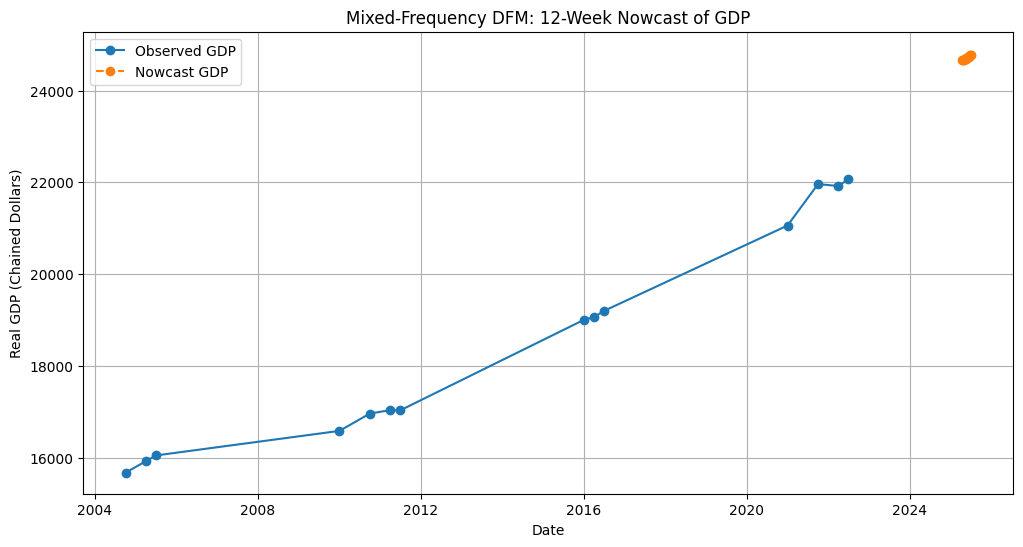

Nowcasted GDP values (original scale):
2025-04-18    24662.87
2025-04-25    24665.23
2025-05-02    24672.41
2025-05-09    24682.00
2025-05-16    24692.80
2025-05-23    24704.21
2025-05-30    24715.91
2025-06-06    24727.77
2025-06-13    24739.70
2025-06-20    24751.67
2025-06-27    24763.66
2025-07-04    24775.66
Freq: W-FRI, dtype: float64


In [36]:
#############################################
# SECTION 6: NOWCAST & FORECAST GDP (12 Weeks Ahead)
#############################################
h = 12  # Forecast horizon in weeks

# Determine the most recent observation date across all series in raw_merged_data
max_date_all = raw_merged_data.index[raw_merged_data.notna().any(axis=1)][-1]
print("Most recent observation in dataset:", max_date_all)

# Use the Kalman filter's forecasting function:
try:
    forecast_obj = final_res.get_forecast(steps=h)
    X_forecast_std = forecast_obj.predicted_mean  # shape (h, N_total)
    print("Forecast obtained via get_forecast()")
except Exception as e:
    print(f"get_forecast() failed: {e}")
    # Fallback: Manual forecast (if necessary)
    q = final_Lambda.shape[1]
    A1 = np.full((q,), 0.5)
    A2 = np.full((q,), 0.2)
    F_forecast = np.zeros((q, h))
    F_forecast[:, 0] = F_final[:, -1]
    if h > 1:
        F_forecast[:, 1] = F_final[:, -2]
    for t in range(2, h):
        F_forecast[:, t] = A1 * F_forecast[:, t-1] + A2 * F_forecast[:, t-2] + np.random.normal(0, 0.1, q)
    X_forecast_std = (final_Lambda @ F_forecast).T
    print("Forecast computed manually via VAR(2) on latent factors.")

# Get forecasted GDP (using GDPC1's column index)
gdp_idx = idx_gdp  # from Section 3
gdp_forecast_std = X_forecast_std[:, gdp_idx]

# Unstandardize GDP forecast using raw GDP series statistics from raw_merged_data:
gdp_raw_series = raw_merged_data["GDPC1"].dropna()
gdp_mean_val = gdp_raw_series.mean(skipna=True)
gdp_std_val  = gdp_raw_series.std(skipna=True)
gdp_forecast_actual = gdp_forecast_std * gdp_std_val + gdp_mean_val

forecast_index = pd.date_range(max_date_all + pd.DateOffset(weeks=1), periods=h, freq="W-FRI")

plt.figure(figsize=(12, 6))
plt.plot(gdp_raw_series.index, gdp_raw_series, 'o-', label="Observed GDP")
plt.plot(forecast_index, gdp_forecast_actual, 'o--', label="Nowcast GDP")
plt.fill_between(forecast_index,
                 gdp_forecast_actual - 0.02 * gdp_std_val,
                 gdp_forecast_actual + 0.02 * gdp_std_val,
                 color='red', alpha=0.3)
plt.xlabel("Date")
plt.ylabel("Real GDP (Chained Dollars)")
plt.title("Mixed-Frequency DFM: 12-Week Nowcast of GDP")
plt.legend()
plt.grid(True)
plt.show()

print("Nowcasted GDP values (original scale):")
print(pd.Series(gdp_forecast_actual.flatten(), index=forecast_index).round(2))

In [30]:
raw_gdp_series

2000-01-07   NaN
2000-01-14   NaN
2000-01-21   NaN
2000-01-28   NaN
2000-02-04   NaN
              ..
2025-03-14   NaN
2025-03-21   NaN
2025-03-28   NaN
2025-04-04   NaN
2025-04-11   NaN
Freq: W-FRI, Name: GDPC1, Length: 1319, dtype: float64